**Mounting the drive and importing/downloading the necessary libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import os
import tensorflow as tf

import cv2    ##used to save the patches in .jpeg format
from sklearn.model_selection import train_test_split

import IPython.display as display
import matplotlib.pyplot as plt
import random

from tensorflow.keras import datasets, layers, models

Mounted at /content/drive


In [2]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (191 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

**Using the address of the shortcut (created in my drive) for the folder containing the slides and the masks and selecting a few of them**

In [4]:
data_dir = "/content/drive/MyDrive/slides/"
files = os.listdir(data_dir)

In [5]:
## adding all the tumor slide names to a list
all_image_names = [] 
for x in files:
  if (".xml" not in x) and ("mask" not in x):
    all_image_names.append(x)

In [6]:
## adding the corresponding tumor mask file names to a list
all_image_masks = []
for x in files:
  if "mask" in x:
    all_image_masks.append(x)

In [7]:
## we remove tumor_038.tif if present as it does not have it's corresponding mask
remove = "tumor_038.tif"
for n,x in enumerate(all_image_names):
  if x == remove:
    all_image_names.pop(n)

## creating two new lists containing the image paths to the above tumors and their correponding masks
image_paths = []
image_paths_mask = []
for x in range(len(all_image_names)):
  image_paths.append(data_dir + all_image_names[x])
  image_paths_mask.append(data_dir + all_image_masks[x])

**Uploading all the slides and their correspoding masks from the folder to a GCP bucket for easier access and use**


In [ ]:
## configuring the project and user authentication to use GCP
from google.colab import auth
auth.authenticate_user()
project_id = 'computer-systems-341920'
!gcloud config set project {project_id}
!gsutil ls

In [ ]:
## uploading the slides and their correspoding masks to a specified bucket
bucket_name = 'hw3_adl'
for x in zip(image_paths,image_paths_mask):
  n1 = x[0]
  n2 = x[1]
  !gsutil -m cp $n1 gs://{bucket_name}/
  !gsutil -m cp $n2 gs://{bucket_name}/

**Download few slides and tumor masks from the bucket (this is optional, we have directly accessed the slides folder in google drive)**


In [8]:
colab_root = "/content/"
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [ ]:
## downloading a few slides and their masks from the bucket
BUCKET_URL ="https://storage.googleapis.com/hw3_adl/"
files = 15
count = 0
for x in zip(all_image_names,all_image_masks):
  count = count + 1
  n1 = x[0]
  n2 = x[1]
  file_path = colab_root + n1
  file_path_mask = colab_root + n2
  download_if_missing(BUCKET_URL + n1,file_path)
  download_if_missing(BUCKET_URL + n2,file_path_mask)
  if count >= files:
    break

54282736/54282736 [==============================] - 1s 0us/step


**Read the slides using Openslide**

In [9]:
## printing the various zoom levels and their respective downsampling factors
## along with the dimensions of the image at every zoom level
## also applying certain sanity checks
file_path = data_dir+"tumor_101.tif"
file_path_mask = data_dir + "tumor_101_mask.tif"

slide = open_slide(file_path)
print ("Read WSI from %s with width: %d, height: %d" % (file_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(file_path_mask)
print ("Read tumor mask from %s" % (file_path_mask))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(tumor_mask.level_dimensions)):
  print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
  assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
  assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /content/drive/MyDrive/slides/tumor_101.tif with width: 139264, height: 71680
Read tumor mask from /content/drive/MyDrive/slides/tumor_101_mask.tif
Slide includes %d levels 10
Level 0, dimensions: (139264, 71680) downsample factor 1
Level 1, dimensions: (69632, 35840) downsample factor 2
Level 2, dimensions: (34816, 17920) downsample factor 4
Level 3, dimensions: (17408, 8960) downsample factor 8
Level 4, dimensions: (8704, 4480) downsample factor 16
Level 5, dimensions: (4352, 2240) downsample factor 32
Level 6, dimensions: (2176, 1120) downsample factor 64
Level 7, dimensions: (1088, 560) downsample factor 128
Level 8, dimensions: (544, 280) downsample factor 256


In [ ]:
## applying certain checks on all the files in the slides folder 
## making sure that the mask and the slide have same dimensions at same levels
## also making sure that the downsampling factor is correct
for x in all_image_names:
  file_path = data_dir + x
  file_path_mask = data_dir + x.split(".")[0] + "_mask." + x.split(".")[1]
  slide = open_slide(file_path)
  tumor_mask = open_slide(file_path_mask)
  for i in range(len(tumor_mask.level_dimensions)):
    try: 
      tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]
    except:
      print("File" , x , "is corrupted")
  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

In [11]:
# Note: x,y coords are with respect to level 0.
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    ## top left on the image is the origin. 
    ## (x,y) -- coordinates of the top left point on the patch
    ## height and width of the patch are also passed onto the fn.
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    ## making sure the read_region function and conversion to RGB has taken place
    assert im.shape == (height, width, 3)
    return im

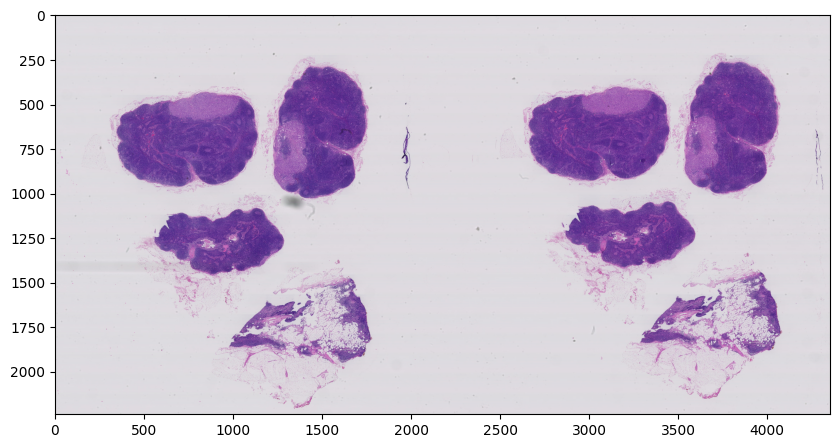

In [11]:
# reading the entire slide at level 5
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

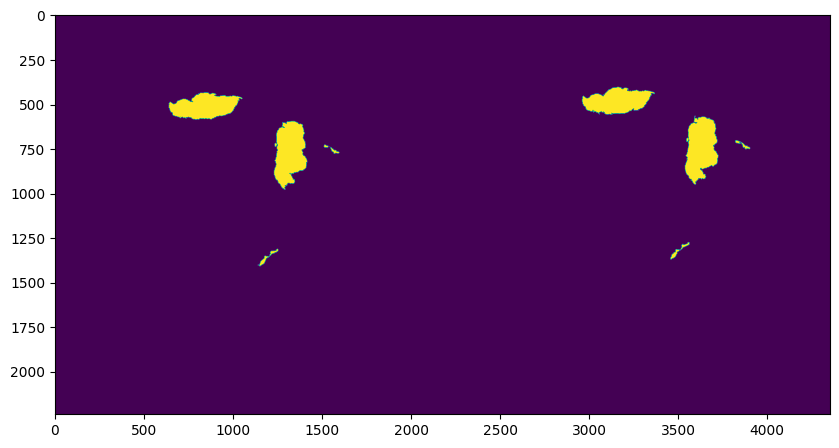

In [12]:
#read the entire mask at the same zoom level (NOTE: the mask is binary, pixel values are either 0 or 1)
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# the above generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

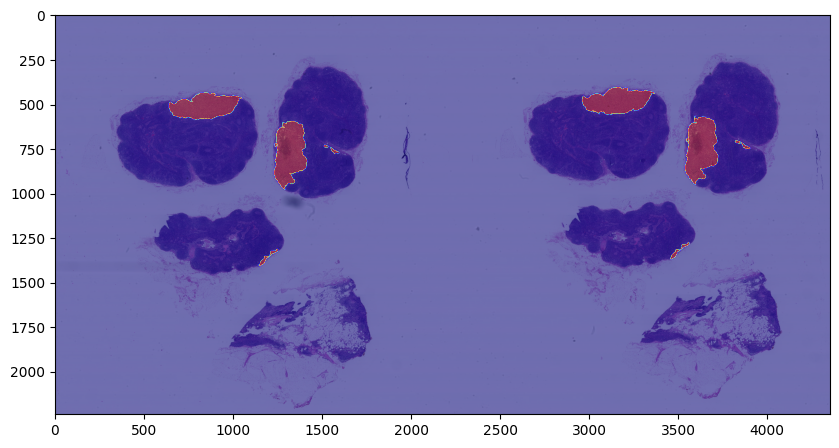

In [13]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

**Performing the sliding window operation at Level 5 zoom and visualizing the cancerous patches (based on a 20% threshold) along with their masks and overlaps for one example to check if the sliding window operation is working properly**

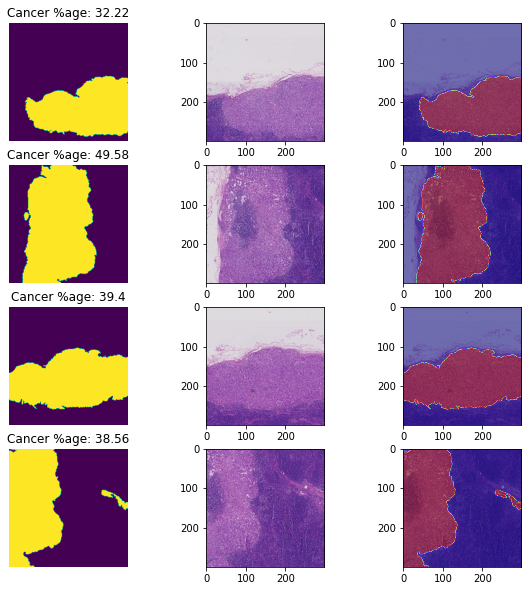

In [14]:
## Rolling a non overlapping sliding window of size 299X299 (size taken from the paper)
## Setting the threshold at 20%, the patch will be labelled as cancerous if more than 20% of the pixels are cancerous
## Visualizing the cancerous patches, their corresponding masks and the overlap of the two images to verify if the results look correct

slide_dim = 299
level = 5
dwn_smpls = int(slide.level_downsamples[level])
x_range = slide.level_dimensions[level][0]
y_range = slide.level_dimensions[level][1]
x_lt = int(x_range/slide_dim)
y_lt = int(y_range/slide_dim)
fig = plt.figure(figsize=(10, 10))
count = 0
for x in range(x_lt):
  for y in range(y_lt):
    # region = read_slide(slide, x=slide_dim*x, y=slide_dim *y, level=level, width=slide_dim, height=slide_dim)
    region_mask = read_slide(tumor_mask, x=x*slide_dim*dwn_smpls, y=y*slide_dim*dwn_smpls, level=level, width=slide_dim, height=slide_dim)[:,:,0]
    cancer_tissue = round((sum(map(sum, region_mask))/slide_dim**2)*100,2)
    ## if there is more than 20% caneruous pixels in the patch, consider it cancerous
    if cancer_tissue > 20:
      count = count + 1
      fig.add_subplot(4, 3, count)
      plt.imshow(region_mask)
      plt.axis('off')
      plt.title("Cancer %age: " + str(round((sum(map(sum, region_mask))/slide_dim**2)*100,2)))
      region = read_slide(slide, x=x*slide_dim*dwn_smpls, y=y*slide_dim*dwn_smpls, level=level, width=slide_dim, height=slide_dim)
      count = count + 1
      fig.add_subplot(4, 3, count)
      plt.imshow(region)
      count = count + 1
      fig.add_subplot(4, 3, count)
      plt.imshow(region)
      plt.imshow(region_mask, cmap='jet', alpha=0.5)

**Function definitions**

In [10]:
## the below function returns the pixels that belong to a tissue using an intensity threshold on the grayscale img
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

## defining a function to perform the sliding window operation on a slide and save the patches along with the labels 
## the function takes in the following inputs
## -- filename (e.g. tumor_075.tif)
## -- zoom level 
## -- height and width of the sliding window
## -- thresholds for %age tissue and %age cancer 
## -- paths to the slide directory and where to save the patches

def patch_save(filename,level,height,width,tissue_thresh,cancer_thresh,path_to_dir,path_to_save):

  slide = open_slide(path_to_dir + filename)
  tumor_mask = open_slide(path_to_dir + filename.split(".")[0] + "_mask." + filename.split(".")[1])
  dwn_smpls = int(slide.level_downsamples[level])
  x_range = slide.level_dimensions[level][0]
  y_range = slide.level_dimensions[level][1]
  x_lt = int(x_range/width)
  y_lt = int(y_range/height)
  count = 0
  for x in range(x_lt):
    for y in range(y_lt):
      region = read_slide(slide, x= x*width*dwn_smpls, y= y*height*dwn_smpls, level=level, width=width, height=height)
      region_mask = read_slide(tumor_mask, x=x*width*dwn_smpls, y=y*height*dwn_smpls, level=level, width=width, height=height)[:,:,0]

      cancer_tissue = round((sum(map(sum, region_mask))/height*width)*100,2)
      percent_tissue = len(find_tissue_pixels(region)) / float(height * width) * 100
      count = count + 1
      if (percent_tissue > tissue_thresh):
        if cancer_tissue  > cancer_thresh:
          save_file = filename.split(".")[0] + "_patch_" + str(count) + "_lvl_" + str(level) + "_" + "01.jpeg"
          cv2.imwrite(path_to_save + save_file,region)
        else:
          save_file = filename.split(".")[0] + "_patch_" + str(count) + "_lvl_" + str(level) + "_" + "00.jpeg"
          cv2.imwrite(path_to_save + save_file,region)
      else:
        continue

**Due to limitation of computational power we look at all the slides and their cancer percentage and select the 9 most decent looking samples just by visual inception (as we only have 22 slides this works here, in case of large datasets a threshold on tissue and cancer percentage can be created)**


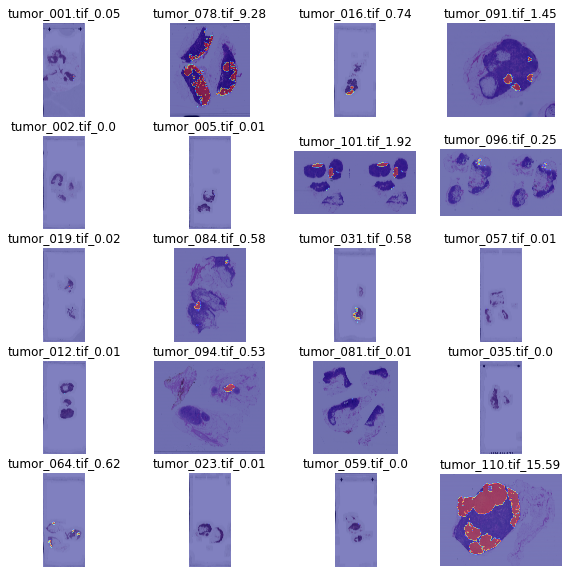

In [ ]:
fig, axs = plt.subplots(5,4, figsize=(10, 10))
for i,x in enumerate(all_image_names):
  slide = open_slide(data_dir + x)
  tumor_mask = open_slide(data_dir + x.split(".")[0] + "_mask."+ x.split(".")[1])
  region_mask = read_slide(tumor_mask, x=0, y=0, level=5,  width=slide.level_dimensions[5][0], height=slide.level_dimensions[5][1])[:,:,0]
  slide_image = read_slide(slide, 
                          x=0, 
                          y=0, 
                          level=5, 
                          width=slide.level_dimensions[5][0], 
                          height=slide.level_dimensions[5][1])
  # percent_tissue = round(len(find_tissue_pixels(slide_image)) / float(slide_image.shape[0] * slide_image.shape[1]),2) * 100
  cancer_tissue = round((sum(map(sum, region_mask))/float(slide_image.shape[0] * slide_image.shape[1]))*100,2)

  axs[i%5,i%4].axis('off')
  axs[i%5,i%4].set_title(str(x)+"_"+str(cancer_tissue))
  axs[i%5,i%4].imshow(slide_image)
  axs[i%5,i%4].imshow(region_mask, cmap='jet', alpha=0.5)

**Creating a split of 4, 3, 2 for train, validation and test from the 9 slides above**


In [12]:
train_slide_names = ["tumor_016.tif","tumor_110.tif","tumor_075.tif","tumor_096.tif"]
val_slide_names = ["tumor_078.tif","tumor_101.tif","tumor_081.tif"]
test_slide_names = ["tumor_091.tif","tumor_084.tif"]

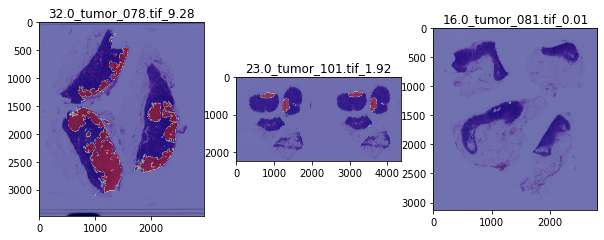

In [ ]:
## printing the overlap of mask and slides in the validation set
fig, axs = plt.subplots(1,3, figsize=(10, 10))
for i,x in enumerate(val_slide_names):
  slide = open_slide(data_dir + x)
  tumor_mask = open_slide(data_dir + x.split(".")[0] + "_mask."+ x.split(".")[1])
  region_mask = read_slide(tumor_mask, x=0, y=0, level=5,  width=slide.level_dimensions[5][0], height=slide.level_dimensions[5][1])[:,:,0]
  slide_image = read_slide(slide, 
                          x=0, 
                          y=0, 
                          level=5, 
                          width=slide.level_dimensions[5][0], 
                          height=slide.level_dimensions[5][1])
  percent_tissue = round(len(find_tissue_pixels(slide_image)) / float(slide_image.shape[0] * slide_image.shape[1]),2) * 100
  cancer_tissue = round((sum(map(sum, region_mask))/float(slide_image.shape[0] * slide_image.shape[1]))*100,2)

  axs[i].set_title(str(percent_tissue)+"_"+str(x)+"_"+str(cancer_tissue))
  axs[i].imshow(slide_image)
  axs[i].imshow(region_mask, cmap='jet', alpha=0.5)

In [13]:
## location of saving the patches
labelled_data_dir = "/content/drive/MyDrive/Final_Project_Data/"

In [14]:
## sanity check 
for x in train_slide_names:
  if (x in test_slide_names) or (x in val_slide_names):
    print("Overlapping slides in data split")
for x in val_slide_names:
  if x in test_slide_names:
    print("Overlapping slides in data split")

**Creating the training, validation and test dataset by calling the patch save function at two different zoom levels and saving the patches in respective folders in Google Drive**

In [ ]:
## running the patch_save function on all the training slides at Zoom level 4 and 5 and saving the patches in GDrive
## we run this with a 25% tissue threshold and a 0% cancer threshold
for x in train_slide_names:
  patch_save(x,4,299,299,25,0,data_dir,labelled_data_dir + "Level4_Train/")
  patch_save(x,3,299,299,25,0,data_dir,labelled_data_dir + "Level3_Train/")

In [15]:
print("We have",len(os.listdir(labelled_data_dir + "Level4_Train")),"Patches in the Training set at zoom level 4")
print("We have",len(os.listdir(labelled_data_dir + "Level3_Train")),"Patches in the Training set at zoom level 3")

# saving all the patch paths and their labels in a list 
train_image_paths_zoom1 = []
train_labels_zoom1 = []
train_image_paths_zoom2 = []
train_labels_zoom2 = []
for x in os.listdir(labelled_data_dir + "Level4_Train"):
  ## files names have label after the last "_" in the file name (00 or 01)
  label = int((x.split(".")[0]).split("_")[-1])
  train_labels_zoom1.append(label)

  image_path = labelled_data_dir + "Level4_Train/" + x
  train_image_paths_zoom1.append(image_path)

for x in os.listdir(labelled_data_dir + "Level3_Train"):
  ## files names have label after the last "_" in the file name (00 or 01)
  label = int((x.split(".")[0]).split("_")[-1])
  train_labels_zoom2.append(label)

  image_path = labelled_data_dir + "Level3_Train/" + x
  train_image_paths_zoom2.append(image_path)  
print("% age of patches having cancer in the training set at Level 4 is: ", sum(train_labels_zoom1)*100/len(train_labels_zoom1))
print("% age of patches having cancer in the training set at Level 3 is: ", sum(train_labels_zoom2)*100/len(train_labels_zoom2))

We have 317 Patches in the Training set at zoom level 4
We have 1194 Patches in the Training set at zoom level 3
% age of patches having cancer in the training set at Level 4 is:  36.90851735015773
% age of patches having cancer in the training set at Level 3 is:  30.569514237855948


In [ ]:
## similarly running the save_patch function to create validation patches at the same zoom levels
for x in val_slide_names:
  patch_save(x,4,299,299,25,0,data_dir,labelled_data_dir + "Level4_Val/")
  patch_save(x,3,299,299,25,0,data_dir,labelled_data_dir + "Level3_Val/")

In [16]:
print("We have",len(os.listdir(labelled_data_dir + "Level4_Val")),"Patches in the Validation set at zoom level 4")
print("We have",len(os.listdir(labelled_data_dir + "Level3_Val")),"Patches in the Validation set at zoom level 3")

# saving all the patch paths and their labels in a list 
val_image_paths_zoom1 = []
val_labels_zoom1 = []
val_image_paths_zoom2 = []
val_labels_zoom2 = []
for x in os.listdir(labelled_data_dir + "Level4_Val"):
  ## files names have label after the last "_" in the file name (00 or 01)
  label = int((x.split(".")[0]).split("_")[-1])
  val_labels_zoom1.append(label)

  image_path = labelled_data_dir + "Level4_Val/" + x
  val_image_paths_zoom1.append(image_path)

for x in os.listdir(labelled_data_dir + "Level3_Val"):
  ## files names have label after the last "_" in the file name (00 or 01)
  label = int((x.split(".")[0]).split("_")[-1])
  val_labels_zoom2.append(label)

  image_path = labelled_data_dir + "Level3_Val/" + x
  val_image_paths_zoom2.append(image_path)  
print("% age of patches having cancer in the Validation set at Level 4 is: ", sum(val_labels_zoom1)*100/len(val_labels_zoom1))
print("% age of patches having cancer in the Validation set at Level 3 is: ", sum(val_labels_zoom2)*100/len(val_labels_zoom2))

We have 383 Patches in the Validation set at zoom level 4
We have 1385 Patches in the Validation set at zoom level 3
% age of patches having cancer in the Validation set at Level 4 is:  35.50913838120105
% age of patches having cancer in the Validation set at Level 3 is:  28.231046931407942


In [ ]:
## similarly running the save_patch function to create validation patches at the same zoom levels
for x in test_slide_names:
  patch_save(x,4,299,299,25,0,data_dir,labelled_data_dir + "Level4_Test/")
  patch_save(x,3,299,299,25,0,data_dir,labelled_data_dir + "Level3_Test/")

In [17]:
print("We have",len(os.listdir(labelled_data_dir + "Level4_Test")),"Patches in the Test set at zoom level 4")
print("We have",len(os.listdir(labelled_data_dir + "Level3_Test")),"Patches in the Test set at zoom level 3")

# saving all the patch paths and their labels in a list 
test_image_paths_zoom1 = []
test_labels_zoom1 = []
test_image_paths_zoom2 = []
test_labels_zoom2 = []
for x in os.listdir(labelled_data_dir + "Level4_Test"):
  ## files names have label after the last "_" in the file name (00 or 01)
  label = int((x.split(".")[0]).split("_")[-1])
  test_labels_zoom1.append(label)

  image_path = labelled_data_dir + "Level4_Test/" + x
  test_image_paths_zoom1.append(image_path)

for x in os.listdir(labelled_data_dir + "Level3_Test"):
  ## files names have label after the last "_" in the file name (00 or 01)
  label = int((x.split(".")[0]).split("_")[-1])
  test_labels_zoom2.append(label)

  image_path = labelled_data_dir + "Level3_Test/" + x
  test_image_paths_zoom2.append(image_path)  
print("% age of patches having cancer in the Validation set at Level 4 is: ", sum(test_labels_zoom1)*100/len(test_labels_zoom1))
print("% age of patches having cancer in the Validation set at Level 3 is: ", sum(test_labels_zoom2)*100/len(test_labels_zoom2))

We have 126 Patches in the Test set at zoom level 4
We have 466 Patches in the Test set at zoom level 3
% age of patches having cancer in the Validation set at Level 4 is:  19.047619047619047
% age of patches having cancer in the Validation set at Level 3 is:  11.587982832618026


**Packaging the data into tensorflow format for the model to digest**

In [18]:
## function to read the image from the image paths we pass 
## also normalizes the image
def load_and_preprocess_image(img):  
  img = tf.io.read_file(img)
  img = tf.image.decode_jpeg(img, channels=3)
  #convert image pixel data type to float and normalize pixels to 0,1
  img_final = tf.cast(img, tf.float32) / 255.0
  return img_final

In [19]:
def show(img, label):
    plt.imshow(img)
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
    print()

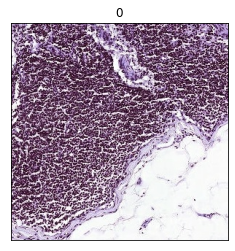

In [20]:
## visualizing a patch after preprocessing
img = load_and_preprocess_image(train_image_paths_zoom2[0])
label = train_labels_zoom2[0]
show(img, label)

In [21]:
## having different batch and shuffle sizes 
## this is because as we go to higher zoom levels we get more patches
SHUFFLE_SIZE_1 = 25
SHUFFLE_SIZE_2 =  100
BATCH_SIZE_1 = 16
BATCH_SIZE_2 = 32
IMG_SIZE = 299

In [22]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths_zoom1)
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels_zoom1, tf.int64))
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
# checking the concatenated dataset by prining image shape and label
for img, label in image_label_ds.take(2):
    print(img.shape, label.numpy())

(299, 299, 3) 0
(299, 299, 3) 0


In [23]:
## using in memory caching as we do not have a large dataset right now
train_ds_zoom1 = image_label_ds.cache()
train_ds_zoom1 = train_ds_zoom1.shuffle(SHUFFLE_SIZE_1)
train_ds_zoom1 = train_ds_zoom1.batch(BATCH_SIZE_1).prefetch(buffer_size=AUTOTUNE)

In [24]:
## following the similar steps as above for zoom level 2 for training
path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths_zoom2)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels_zoom2, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
train_ds_zoom2 = image_label_ds.cache()
train_ds_zoom2 = train_ds_zoom2.shuffle(SHUFFLE_SIZE_2)
train_ds_zoom2 = train_ds_zoom2.batch(BATCH_SIZE_2).prefetch(buffer_size=AUTOTUNE)

In [25]:
## following the similar steps as above for zoom level 1 for validation
path_ds = tf.data.Dataset.from_tensor_slices(val_image_paths_zoom1)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(val_labels_zoom1, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
val_ds_zoom1 = image_label_ds.cache().batch(BATCH_SIZE_1)

## following the similar steps as above for zoom level 2 for validation
path_ds = tf.data.Dataset.from_tensor_slices(val_image_paths_zoom2)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(val_labels_zoom2, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
val_ds_zoom2 = image_label_ds.cache().batch(BATCH_SIZE_2)

In [26]:
## following the similar steps as above for zoom level 1 for test
path_ds = tf.data.Dataset.from_tensor_slices(test_image_paths_zoom1)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels_zoom1, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds_zoom1 = image_label_ds.cache().batch(BATCH_SIZE_1)

## following the similar steps as above for zoom level 2 for test
path_ds = tf.data.Dataset.from_tensor_slices(test_image_paths_zoom2)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels_zoom2, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds_zoom2 = image_label_ds.cache().batch(BATCH_SIZE_2)

**Below we create two identical Models (one for each zoom level) by using Tranfer Learning and doing fine tuning of the InceptionV3 model**




In [27]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model

inception_base_zoom1 = InceptionV3(weights='imagenet',
                                    include_top=False,
                                    input_shape=(IMG_SIZE, IMG_SIZE, 3))

inception_base_zoom2 = InceptionV3(weights='imagenet',
                                    include_top=False,
                                    input_shape=(IMG_SIZE, IMG_SIZE, 3))

# freeze the inception model to increase training speed
inception_base_zoom1.trainable = True
inception_base_zoom2.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(inception_base_zoom1.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer for zoom1 model
for layer in inception_base_zoom1.layers[:fine_tune_at]:
  layer.trainable = False
# Freeze all the layers before the `fine_tune_at` layer for zoom2 model
for layer in inception_base_zoom2.layers[:fine_tune_at]:
  layer.trainable = False

87910968/87910968 [==============================] - 3s 0us/step
Number of layers in the base model:  311


In [28]:
input_z1 = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
input_z2 = Input(shape=(IMG_SIZE, IMG_SIZE, 3))


## we do global average pooling after adding the inception model to reduce the number of trainable params
model_z1 = Sequential()
model_z1.add(inception_base_zoom1)
model_z1.add(GlobalAveragePooling2D())

model_z2 = Sequential()
model_z2.add(inception_base_zoom2)
model_z2.add(GlobalAveragePooling2D())

encoded_input_z1 = model_z1(input_z1)
encoded_input_z2 = model_z2(input_z2)

In [29]:
## create a model for the 1st zoom level
dense1 = Dense(256, activation='relu')(encoded_input_z1)
drop_layer = Dropout(0.5)(dense1)
dense2 = Dense(126, activation='relu')(drop_layer)

output = Dense(1, activation='sigmoid')(dense2)
model1 = Model(inputs=input_z1, outputs=output)

In [30]:
## create a model for the 2nd zoom level
dense1 = Dense(256, activation='relu')(encoded_input_z2)
drop_layer = Dropout(0.5)(dense1)
dense2 = Dense(126, activation='relu')(drop_layer)

output = Dense(1, activation='sigmoid')(dense2)
model2 = Model(inputs=input_z2, outputs=output)

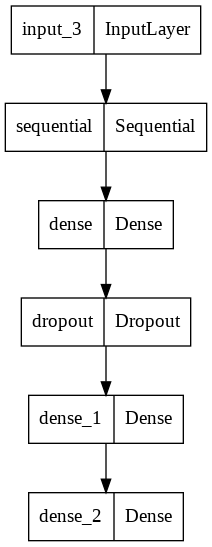

In [31]:
## we have two models like the one shown below in the plot
plot_model(model1, to_file='model.png')

In [32]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 126)               32382     
                                                                 
 dense_2 (Dense)             (None, 1)                 127       
                                                                 
Total params: 22,359,837
Trainable params: 20,183,421
Non-tra

In [33]:
model1.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

**Below we train both the models and create checkpoints to save the weights after every epoch**

In [39]:
## creating checkpoint directory
checkpoint_path1 =  labelled_data_dir + "training2_dec22_batch_8_lvl_4/cp.ckpt"
checkpoint_dir1 = os.path.dirname(checkpoint_path1)

## loading the weights from the last checkpoint before we further continue training
latest1 = tf.train.latest_checkpoint(checkpoint_dir1)
if latest1 != None:
  print("Loading weights from", latest1)
  model1.load_weights(latest1)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from /content/drive/MyDrive/Final_Project_Data/training2_dec22_batch_8_lvl_4/cp.ckpt


In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path1,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
hist1 = model1.fit(train_ds_zoom1,validation_data=val_ds_zoom1,epochs=20,callbacks=[cp_callback])

Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 0.7118 - accuracy: 0.6688
Epoch 1: saving model to /content/drive/MyDrive/Final_Project_Data/training2_dec22_batch_8_lvl_4/cp.ckpt
40/40 [==============================] - 7s 177ms/step - loss: 0.7118 - accuracy: 0.6688 - val_loss: 6.4968 - val_accuracy: 0.6710
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.6050 - accuracy: 0.7476
Epoch 2: saving model to /content/drive/MyDrive/Final_Project_Data/training2_dec22_batch_8_lvl_4/cp.ckpt
40/40 [==============================] - 7s 170ms/step - loss: 0.6050 - accuracy: 0.7476 - val_loss: 2.6530 - val_accuracy: 0.6762
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.7192
Epoch 3: saving model to /content/drive/MyDrive/Final_Project_Data/training2_dec22_batch_8_lvl_4/cp.ckpt
40/40 [==============================] - 7s 167ms/step - loss: 0.6341 - accuracy: 0.7192 - val_loss: 2.0366 - val_accuracy: 0.6475
Epoch 4/20

In [34]:
checkpoint_path2 =  labelled_data_dir + "training2_dec22_batch_16_lvl_3/cp.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)

latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
if latest2 != None:
  print("Loading weights from", latest2)
  model2.load_weights(latest2)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


In [35]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path2,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
hist2 = model2.fit(train_ds_zoom2,validation_data=val_ds_zoom2,epochs=20,callbacks=[cp_callback])

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.8208
Epoch 1: saving model to /content/drive/MyDrive/Final_Project_Data/training2_dec22_batch_16_lvl_3/cp.ckpt
38/38 [==============================] - 657s 16s/step - loss: 0.4481 - accuracy: 0.8208 - val_loss: 16.7383 - val_accuracy: 0.7177
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.8015
Epoch 2: saving model to /content/drive/MyDrive/Final_Project_Data/training2_dec22_batch_16_lvl_3/cp.ckpt
38/38 [==============================] - 17s 454ms/step - loss: 0.5809 - accuracy: 0.8015 - val_loss: 1095.0538 - val_accuracy: 0.7177
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.7680
Epoch 3: saving model to /content/drive/MyDrive/Final_Project_Data/training2_dec22_batch_16_lvl_3/cp.ckpt
38/38 [==============================] - 17s 451ms/step - loss: 0.5520 - accuracy: 0.7680 - val_loss: 39.6817 - val_accuracy: 0.3495


**Plotting the validation and training accuracy/loss**

In [37]:
def plot(history):
  # The history object contains results on the training and test
  # sets for each epoch
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get the number of epochs
    epochs = range(len(acc))

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    _ = plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

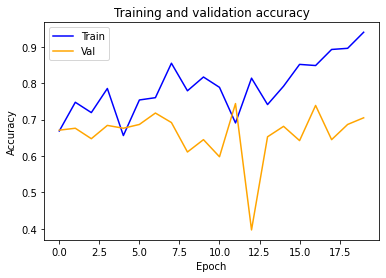

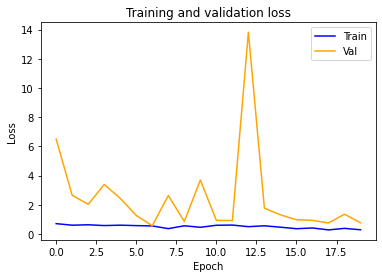

In [ ]:
plot(hist1)

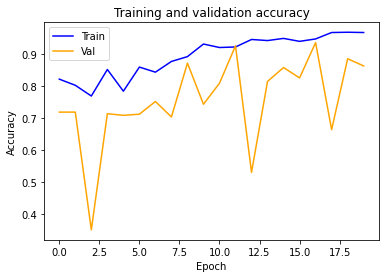

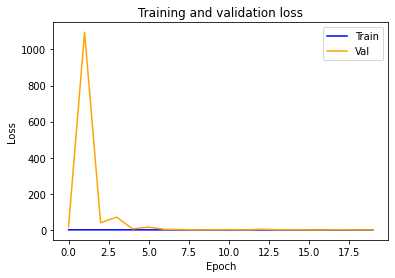

In [38]:
## plotting the training and validation loss and accuracy over the epochs for model2
plot(hist2)

**Testing both the models on the test dataset we created**

In [40]:
## define a function to evaluate the model using the test set
def test_evaluate(test_ds,model,max_steps=None):
  steps = 0
  for path_batch,label_batch in test_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(path_batch)
    steps += 1 
    # Record metrics after each batch
    test_loss(label_batch, predictions)
    test_accuracy(label_batch, predictions)

In [48]:
test_loss = tf.keras.metrics.BinaryCrossentropy(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
test_evaluate(test_ds_zoom1,model1)

1/1 [==============================] - 3s 3s/step


In [51]:
print("The test loss for model1 (Zoom level 4) is: ",test_loss.result().numpy(), "\nThe test accuracy is: ",test_accuracy.result().numpy()*100,"%")

The test loss for model1 (Zoom level 4) is:  0.77775586 
The test accuracy is:  78.57142686843872 %


In [41]:
test_loss = tf.keras.metrics.BinaryCrossentropy(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
test_evaluate(test_ds_zoom2,model2)

1/1 [==============================] - 3s 3s/step


In [42]:
print("The test loss for model2 (Zoom level 3) is: ",test_loss.result().numpy(), "\nThe test accuracy is: ",test_accuracy.result().numpy()*100,"%")

The test loss for model2 (Zoom level 3) is:  0.32616392 
The test accuracy is:  91.84549450874329 %


**Below we define a function to generate a mask heatmap which would tell us as to where the cancer is present using the above models that we trained**

In [43]:
def create_mask(filename,model,level,height,width,path_to_dir):

  slide = open_slide(path_to_dir + filename)
  tumor_mask = open_slide(path_to_dir + filename.split(".")[0] + "_mask." + filename.split(".")[1])
  dwn_smpls = int(slide.level_downsamples[level])
  x_range = slide.level_dimensions[level][0]
  y_range = slide.level_dimensions[level][1]
  x_lt = int(x_range/width)
  y_lt = int(y_range/height)
  prediction = []
  tissue_perc = []
  count = 0
  for x in range(x_lt):
    for y in range(y_lt):

      region = read_slide(slide, x=x*width*dwn_smpls, y=y*height*dwn_smpls, level=level, width=width, height=height)
      region_mask = read_slide(tumor_mask, x=x*width*dwn_smpls, y=y*height*dwn_smpls, level=level, width=width, height=height)[:,:,0]

      percent_tissue = len(find_tissue_pixels(region)) *100 / float(height * width)
      count = count + 1
      tissue_perc.append(percent_tissue)
      temp = model.predict(np.expand_dims(region, axis=0))[0][0]
      ## converting any non zero prediction value to 1
      if temp > 0:
        temp = 1
      prediction.append(temp)
  return np.array(prediction).reshape((x_lt,y_lt))

In [56]:
test_file = "tumor_078.tif"
test_pred = create_mask(test_file,model1,4,299,299,data_dir)

1/1 [==============================] - 0s 270ms/step


**Plotting the overlap of the mask and slide by using both the original mask and the predicted heatmap mask**

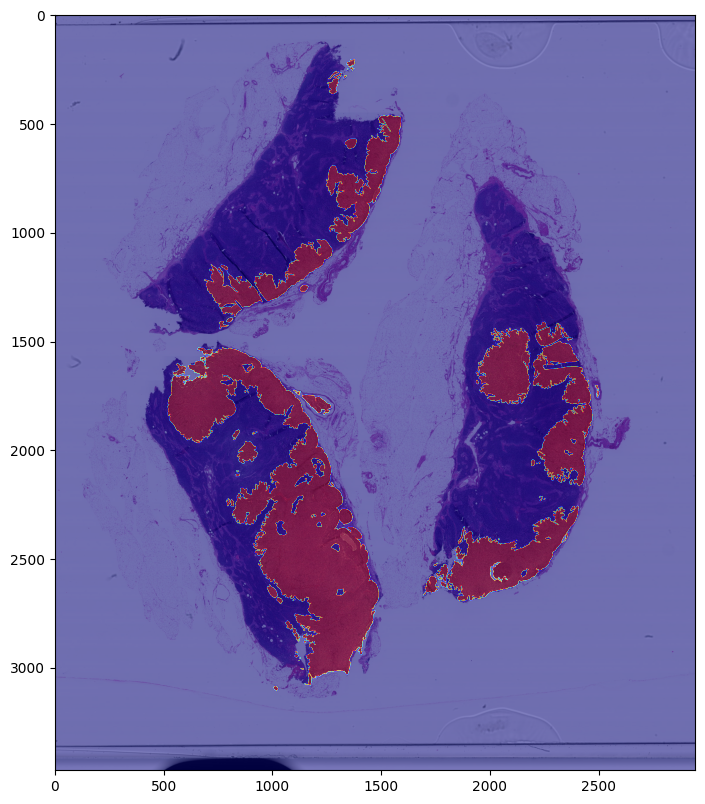

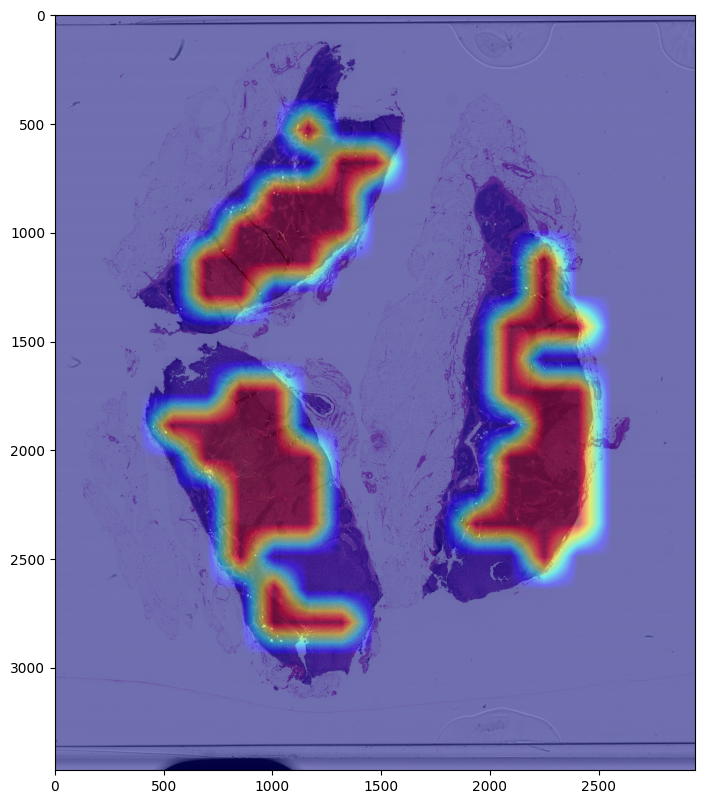

In [62]:
slide_test = open_slide(data_dir + test_file)
mask_test = open_slide(data_dir + test_file.split(".")[0] + "_mask."+ test_file.split(".")[1])

slide_image = read_slide(slide_test, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide_test.level_dimensions[5][0], 
                         height=slide_test.level_dimensions[5][1])
mask_image = read_slide(mask_test, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=mask_test.level_dimensions[5][0], 
                         height=mask_test.level_dimensions[5][1])[:,:,0]
predict_mask = cv2.resize(test_pred.T,(slide_test.level_dimensions[5][0],slide_test.level_dimensions[5][1]))

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(predict_mask, cmap='jet', alpha=0.5)